In [32]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import networkx as nx
import matplotlib.pyplot as plt

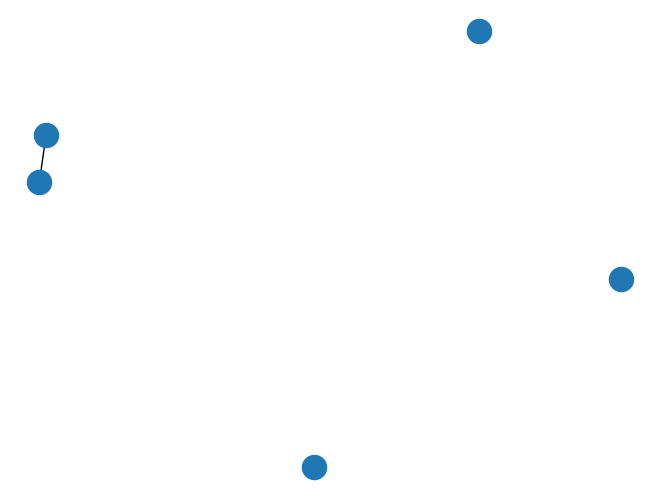

In [34]:
G = nx.Graph()
G.add_node(0, weight=3.0)
G.add_node(1, weight=5.0)
G.add_nodes_from([2,3,4], weight=10.0)
G.add_edge(0,1, weight=1.0)
G.add_edge(1,2, weight=1.0)
G.add_edge(3,4, weight=1.0)
nx.draw(G)

[('1', '2'),
 ('1', '3'),
 ('2', '3'),
 ('3', '4'),
 ('3', '5'),
 ('3', '6'),
 ('4', '6')]